<font color='blue'> **502_GW - 2023 - Hughes - FloPy Structured and Unstructured** </font> ..

In [1]:
import os ; import pathlib as pl ; import sys      ; import shapely ; import yaml ; from shapely.geometry import LineString, Polygon
import matplotlib as mpl ; import matplotlib.gridspec as gridspec ; import matplotlib.pyplot as plt ; import numpy as np
import flopy ; import flopy.plot.styles as styles ; from flopy.discretization import StructuredGrid, VertexGrid
from flopy.utils.gridgen import Gridgen ; from flopy.utils.gridintersect import GridIntersect  
from flopy.utils.triangle import Triangle ; from flopy.utils.voronoi import VoronoiGrid

In [2]:
import pandas as pd ; from pathlib import Path ; sim_ws = Path("./08a_RES") ; sim_ws.mkdir(exist_ok=True)  

In [3]:
def string2geom(geostring, conversion=None):
    if conversion is None:    multiplier = 1.0
    else:                     multiplier = float(conversion)
    res = []
    for line in geostring.split("\n"):
        if not any(line):
            continue
        line = line.strip() ; line = line.split(" ") ; x = float(line[0]) * multiplier ; y = float(line[1]) * multiplier ; res.append((x, y))
    return res

In [4]:
def densify_geometry(line, step, keep_internal_nodes=True):
    xy = []  ;     lines_strings = []
    if keep_internal_nodes:
        for idx in range(1, len(line)):      lines_strings.append(shapely.geometry.LineString(line[idx - 1 : idx + 1]))
    else:                                    lines_strings = [shapely.geometry.LineString(line)]
    for                       line_string in lines_strings:
        length_m = line_string.length  
        for distance in np.arange(0, length_m + step, step):
            point = line_string.interpolate(distance)       ; xy_tuple = (point.x, point.y)
            if xy_tuple not in xy:                            xy.append(xy_tuple)
        if keep_internal_nodes:
            xy_tuple = line_string.coords[-1]
            if xy_tuple not in xy:                            xy.append(xy_tuple)
    return xy

In [5]:
def set_idomain(grid, boundary):
    ix = GridIntersect(grid, method="vertex", rtree=True)    ; result = ix.intersect(Polygon(boundary))
    idx = [coords for coords in result.cellids]              ;    idx = np.array(idx, dtype=int)          ; nr = idx.shape[0]
    if idx.ndim == 1:                                             idx = idx.reshape((nr, 1))
    idx = tuple([idx[:, i] for i in range(idx.shape[1])])    ; idomain = np.zeros(grid.shape[1:], dtype=int)
    idomain[idx] = 1                                         ; idomain = idomain.reshape(grid.shape)      ; grid.idomain = idomain

In [6]:
geometries = yaml.safe_load(open(pl.Path("E:/15_REPOS/00_BETAMI/bin/Flopy_3099/geometries.yml")))

In [7]:
figwidth = 180  ; figwidth = figwidth / 10 / 2.54  ; figheight = figwidth ; figsize = (figwidth, figheight)

In [8]:
contour_color   = "black"  ; contour_style   = "--"         ; clabel_dict  = {"inline": True,"fmt": "%1.0f","fontsize": 6,"inline_spacing": 0.5}
font_dict       = {"fontsize": 5,"color": "black"}          ; grid_dict    = {"lw": 0.25,"color": "0.5"}
refinement_dict = {"color": "magenta","ls": ":","lw": 1.0}  ; river_dict   = {"color": "blue","linestyle": "-","linewidth": 1}
intersection_cmap = "Pastel2"         ; temp_cmap = mpl.colormaps[intersection_cmap]   ; intersection_rgba = temp_cmap(0)

In [9]:
ascii_file = pl.Path("E:/15_REPOS/00_BETAMI/bin/Flopy_3099/fine_topo.asc")  ; fine_topo = flopy.utils.Raster.load(ascii_file)

In [10]:
Lx = 180000 ; Ly = 100000  ; extent = (0, Lx, 0, Ly)  ; vmin, vmax = 0.0, 100.0

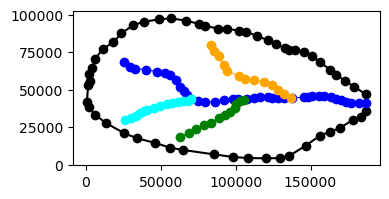

In [11]:
boundary_polygon = string2geom (geometries["boundary"])        ; bpp = np.array(boundary_polygon)
sgs              = [string2geom(geometries[f"streamseg{i}"])   for i in range(1, 5)]
fig = plt.figure(figsize=(6,2))  
ax = fig.add_subplot() ; ax.set_aspect("equal") ; riv_colors = ("blue", "cyan", "green", "orange", "red")  ; ax.plot(bpp[:, 0], bpp[:, 1], "ko-")
for idx, sg in enumerate(sgs):
    sa = np.array(sg)  ; ax.plot(sa[:, 0], sa[:, 1], color=riv_colors[idx], lw=0.75, marker="o")

In [12]:
dx     = dy = 1666.66666667       ; nlay = 1  
nrow   = int(Ly / dy) + 1       ; ncol = int(Lx / dx) + 1 
delr   = np.array(ncol * [dx])  ; delc = np.array(nrow * [dy])          ; top = np.ones((nrow,ncol))*1000.0  ; botm=np.ones((nlay,nrow,ncol))*-100.0
struct_grid = StructuredGrid(nlay=nlay, delr=delr, delc=delc, xoff=0.0, yoff=0.0, top=top, botm=botm)    ; set_idomain(struct_grid, boundary_polygon)
top_sg = fine_topo.resample_to_grid(struct_grid,band=fine_topo.bands[0],method="linear",extrapolate_edges=True)
ixs    = flopy.utils.GridIntersect(struct_grid, method="vertex")        ; cellids = []   # vertex / structured
for sg in sgs: v = ixs.intersect(LineString(sg), sort_by_cellid=True)   ; cellids += v["cellids"].tolist()
intersection_sg = np.zeros(struct_grid.shape[1:])
for loc in cellids:                                              intersection_sg[loc] = 1

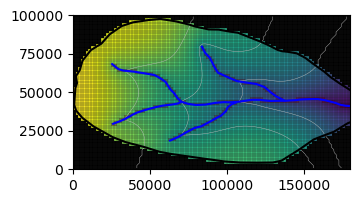

In [13]:
fig = plt.figure(figsize=(6,2))                   ; ss=np.max(top_sg)-np.min(top_sg); levels=np.arange(np.min(top_sg[0]), np.max(top_sg[0]), ss/5)
ax = fig.add_subplot()                            ; pmv = flopy.plot.PlotMapView(modelgrid = struct_grid)
ax.set_aspect("equal") ; pmv.plot_array(top_sg)   ; pmv.plot_array(intersection_sg,masked_values=[0,],alpha=0.2,cmap="Reds_r")
pmv.plot_grid(lw=0.25, color="0.1")          ; cg = pmv.contour_array(top_sg, levels=levels, linewidths=0.3, colors="0.75")   ; pmv.plot_inactive()
ax.plot(bpp[:, 0], bpp[:, 1], "k-")
for sgg in sgs:     saa = np.array(sgg)   ; ax.plot(saa[:, 0], saa[:, 1], "b-")

<font color='blue'> **Variable row and column spacing** </font> 

In [14]:
dx=dy=5000 ;multiplier = 1.175 ;transition=20000.0        ; ncells = 7 ; smoothr=[transition*(multiplier-1.0) / (multiplier**float(ncells)- 1.0)]
for i in range(ncells - 1):     smoothr.append(smoothr[i] * multiplier) ; smooth  = smoothr.copy() ; smooth.reverse()  #; print('smooth', smooth)
dx = 9*[5000]+smooth+15*[1666]+smoothr+14*[5000] ; dy = 4*[5000]+smooth+12*[1666.66666667]+smoothr+4*[5000]
nlay = 1 ; ncol = len(dx) ; nrow = len(dy)       ; top = np.ones((nrow, ncol)) * 1000.0  ; botm = np.ones((nlay, nrow, ncol)) * -100.0
delr = np.array(dx) ;  delc = np.array(dy)       ; struct_vrc_grid = StructuredGrid(nlay=nlay,delr=delr,delc=delc,xoff=0.0,yoff=0.0,top=top ,botm=botm) 
set_idomain(struct_vrc_grid, boundary_polygon)
top_sg_vrc = fine_topo.resample_to_grid(struct_vrc_grid ,band=fine_topo.bands[0] ,method="linear" ,extrapolate_edges=True)
ixs = flopy.utils.GridIntersect(struct_vrc_grid, method="vertex")   ; cellids = []
for sg in sgs: v    = ixs.intersect(LineString(sg), sort_by_cellid=True) ; cellids += v["cellids"].tolist()
intersection_sg_vrc = np.zeros(struct_vrc_grid.shape[1:])
for loc in cellids:  intersection_sg_vrc[loc] = 1

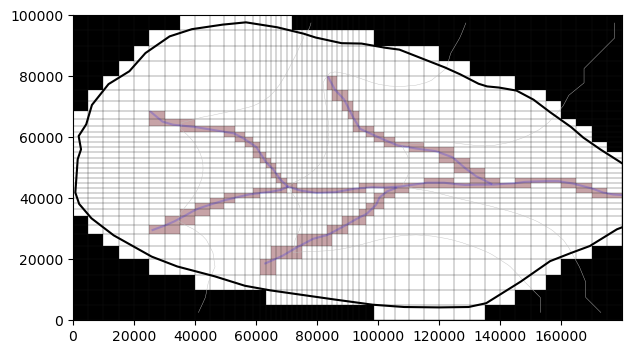

In [15]:
fig = plt.figure(figsize=figsize)   ; ax = fig.add_subplot() ; pmv = flopy.plot.PlotMapView(modelgrid=struct_vrc_grid)
ax.set_aspect("equal") ; pmv.plot_grid(lw=0.25, color="0.1") ; pmv.plot_array(intersection_sg_vrc, masked_values=[0, ],alpha=0.2,cmap="Reds_r")
cg = pmv.contour_array(top_sg_vrc, levels=levels, linewidths=0.3, colors="0.75") ; pmv.plot_inactive() ; ax.plot(bpp[:, 0], bpp[:, 1], "k-")
for sg in sgs: sa = np.array(sg) ; ax.plot(sa[:, 0], sa[:, 1], "b-", alpha=0.2) #pmv.plot_array(top_sg_vrc)

<font color='blue'> **Local grid refinement grid** </font> 

In [16]:
contour_dict    = {"levels": levels,"linewidths": 0.5,"colors": contour_color,"linestyles": contour_style}
from flopy.utils.lgrutil import Lgr

nlayp = 1 ; dx = 5000 ; nrowp = int(Ly / dx)         ; ncolp = int(Lx / dx) ; delrp = dx ; delcp = dx ; # topp = 1000.0 ; # botmp = [-100.]
topp = np.ones((nrowp, ncolp)) * 1000.0              ; botmp = np.ones((nlayp, nrowp, ncolp)) * -100.0
idomainp = np.ones((nlayp, nrowp, ncolp), dtype=int) ; idomainp[0, 8:12, 13:18] = 0

ncpp = 3 ; ncppl = [1]

lgr = Lgr(nlayp,nrowp,ncolp,delrp,delcp,topp,botmp,idomainp,ncpp=ncpp,ncppl=ncppl,xllp=0.0,yllp=0.0)

delr = np.array(ncolp * [dx]) ; delc = np.array(nrowp * [dx])
struct_gridp = StructuredGrid(nlay=1, delr=delr, delc=delc, idomain=idomainp, top=topp, botm=botmp) ; set_idomain(struct_gridp, boundary_polygon)

delr_child, delc_child = lgr.get_delr_delc()   ; xoff, yoff = lgr.get_lower_left()
nrowc, ncolc = delc_child.shape[0], delr_child.shape[0]
topc = np.ones((nrowc, ncolc)) * 1000.0
botmc = np.ones((nlayp, nrowc, ncolc)) * -100.0
struct_gridc = StructuredGrid(delr=delr_child, delc=delc_child, xoff=xoff, yoff=yoff ,idomain=idomainp, top=topc, botm=botmc )

extent_child = struct_gridc.extent

nested_grid = [struct_gridp, struct_gridc]

In [17]:
top_ngp = fine_topo.resample_to_grid(struct_gridp,band=fine_topo.bands[0],method="linear",extrapolate_edges=True)
top_ngc = fine_topo.resample_to_grid(struct_gridc,band=fine_topo.bands[0],method="linear",extrapolate_edges=True)
top_nested_grid = [top_ngp, top_ngc]

In [18]:
ixs = flopy.utils.GridIntersect(struct_gridp, method="vertex")    ; cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)        ; cellids += v["cellids"].tolist()
intersection_ngp = np.zeros(struct_gridp.shape[1:])
for loc in cellids:                                                 intersection_ngp[loc] = 1
intersection_ngp[idomainp[0] == 0] = 0

ixs = flopy.utils.GridIntersect(struct_gridc, method="vertex")     ; cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)         ; cellids += v["cellids"].tolist()
intersection_ngc = np.zeros(struct_gridc.shape[1:])
for loc in cellids:                                                  intersection_ngc[loc] = 1
intersection_nested_grid = [intersection_ngp, intersection_ngc]

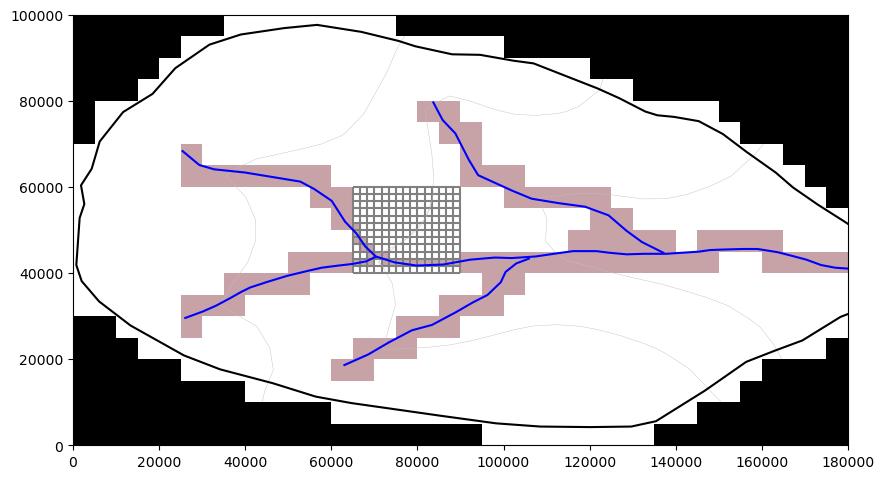

In [19]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot() ; pmv = flopy.plot.PlotMapView(modelgrid=struct_gridp, extent=extent) ; pmv.plot_inactive()
#pmv.plot_array(top_ngp, vmin=vmin, vmax=vmax)
pmv.plot_array(intersection_nested_grid[0],masked_values=[0,],alpha=0.2,cmap="Reds_r")
cgp = pmv.contour_array(top_ngp, levels=levels, linewidths=0.3, colors="0.75") ; pmv.plot_inactive(zorder=100) ; ax.set_aspect("equal")

pmvc = flopy.plot.PlotMapView(modelgrid=struct_gridc, ax=ax, extent=extent) ; pmvc.plot_grid() ; #pmvc.plot_array(top_ngc, vmin=vmin, vmax=vmax)
pmvc.plot_array(intersection_nested_grid[1],masked_values=[0,],alpha=0.2,cmap="Reds_r")
cgc = pmvc.contour_array(top_ngc, levels=levels, linewidths=0.3, colors="0.75")

ax.plot(bpp[:, 0], bpp[:, 1], "k-")
for sg in sgs:     sa = np.array(sg) ;     ax.plot(sa[:, 0], sa[:, 1], "b-")

## <font color='red'> **Unstructured grids**

In [20]:
lgr_poly = [[(extent_child[0], extent_child[2]),(extent_child[0], extent_child[3]),(extent_child[1], extent_child[3]),
             (extent_child[1], extent_child[2]),(extent_child[0], extent_child[2])]]

### Quadtree grid

In [21]:
sim = flopy.mf6.MFSimulation()         ; gwf = gwf = flopy.mf6.ModflowGwf(sim)
dx = dy = 5000.0  ; nr = int(Ly / dy)  ; nc = int(Lx / dx)
dis6 = flopy.mf6.ModflowGwfdis(gwf,nrow=nr,ncol=nc,delr=dy,delc=dx)         ; g = Gridgen(gwf.modelgrid, model_ws=sim_ws)
adpoly = [[[(1000,1000),(3000,1000),(3000,2000),(1000,2000),(1000,1000)]]]  ; adpoly = boundary_polygon + [boundary_polygon[0]] ; adpoly = [[adpoly]]
g.add_refinement_features([lgr_poly], "polygon", 2, range(1))               ; refine_line = sgs
g.add_refinement_features(refine_line, "line", 2, range(1))                 ; g.build(verbose=False)
gridprops_vg = g.get_gridprops_vertexgrid()
quadtree_grid = flopy.discretization.VertexGrid(**gridprops_vg)  ; set_idomain(quadtree_grid, boundary_polygon)

In [22]:
top_qg = fine_topo.resample_to_grid(quadtree_grid,band=fine_topo.bands[0],method="linear",extrapolate_edges=True)

In [23]:
ixs = flopy.utils.GridIntersect(quadtree_grid, method="vertex")   ; cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)   ;     cellids += v["cellids"].tolist()
intersection_qg = np.zeros(quadtree_grid.shape[1:])
for loc in cellids:     intersection_qg[loc] = 1

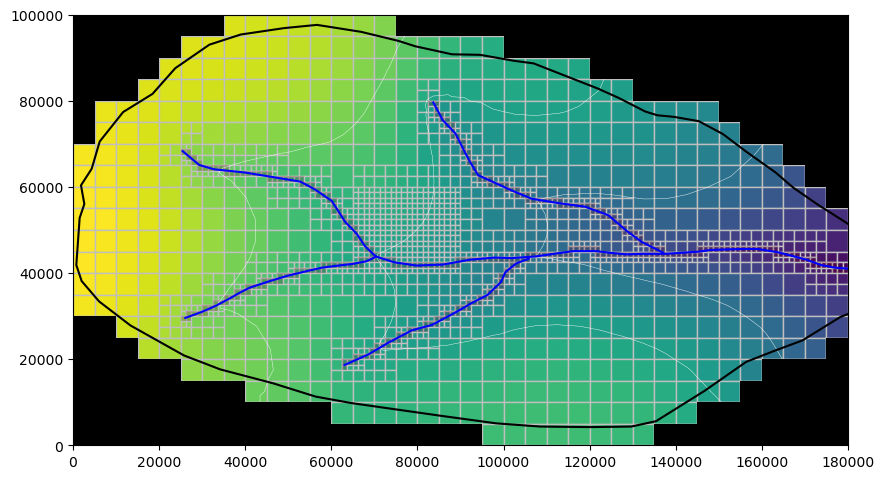

In [24]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=quadtree_grid)
pmv.plot_array(top_qg, ec="0.75")
pmv.plot_array(intersection_qg,masked_values=[0,],alpha=0.2,cmap="Reds_r",)
cg = pmv.contour_array(top_qg, levels=levels, linewidths=0.3, colors="white")
pmv.plot_inactive(zorder=100)
ax.set_aspect("equal")

ax.plot(bpp[:, 0], bpp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

### Triangular grid

In [25]:
nodes = []
for sg in sgs:
    sg_densify = densify_geometry(sg, 2000)
    nodes.extend(sg_densify)
for x in struct_gridc.get_xvertices_for_layer(0)[0, :]:
    for y in struct_gridc.get_yvertices_for_layer(0)[:, 0]:
        nodes.append((x, y))
nodes = np.array(nodes)

In [26]:
tri = Triangle(
    maximum_area=5000 * 5000, angle=30, nodes=nodes, model_ws=sim_ws
)
poly = bpp
tri.add_polygon(poly)
tri.build(verbose=False)


cell2d = tri.get_cell2d()
vertices = tri.get_vertices()

top = np.ones(tri.ncpl) * 1000.0
botm = np.ones((1, tri.ncpl)) * -100.0
idomain = np.ones((1, tri.ncpl), dtype=int)

triangular_grid = VertexGrid(
    vertices=vertices,
    cell2d=cell2d,
    idomain=idomain,
    nlay=1,
    ncpl=tri.ncpl,
    top=top,
    botm=botm,
)

In [27]:
top_tg = fine_topo.resample_to_grid(
    triangular_grid,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [28]:
ixs = flopy.utils.GridIntersect(triangular_grid)  # , method="vertex")
cellids = []
for sg in sgs:
    v = ixs.intersect(
        LineString(sg),
        return_all_intersections=True,
        keepzerolengths=False,
        sort_by_cellid=True,
    )
    cellids += v["cellids"].tolist()
intersection_tg = np.zeros(triangular_grid.shape[1:])
for loc in cellids:
    intersection_tg[loc] = 1

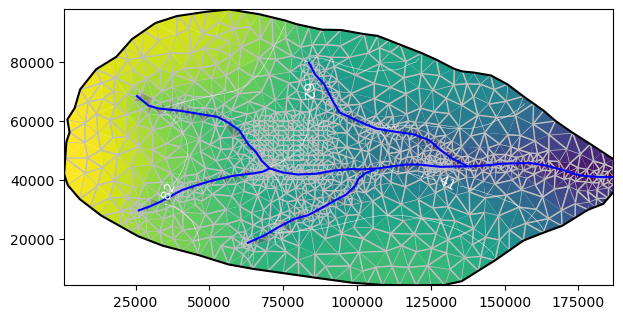

In [29]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.set_aspect("equal")

pmv = flopy.plot.PlotMapView(modelgrid=triangular_grid)

pmv.plot_array(top_tg, ec="0.75")
pmv.plot_array(
    intersection_tg,
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
cg = pmv.contour_array(top_tg, levels=levels, linewidths=0.3, colors="white")
ax.clabel(cg, cg.levels, inline=True, fmt="%1.0f", fontsize=10)

pmv.plot_inactive(zorder=100)

if True:
    ax.plot(bpp[:, 0], bpp[:, 1], "k-")
    for sg in sgs:
        sa = np.array(sg)
        ax.plot(sa[:, 0], sa[:, 1], "b-")

### Voronoi Grid from the Triangle object

In [30]:
# create vor object and VertexGrid from the triangle object tri
vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
idomain = np.ones((1, vor.ncpl), dtype=int)
voronoi_grid = VertexGrid(**gridprops, nlay=1, idomain=idomain)

In [31]:
top_vg = fine_topo.resample_to_grid(
    voronoi_grid,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [32]:
ixs = flopy.utils.GridIntersect(voronoi_grid, method="vertex")
cellids = []
for sg in sgs:
    v = ixs.intersect(
        LineString(sg),
        return_all_intersections=True,
        keepzerolengths=False,
        sort_by_cellid=True,
    )
    cellids += v["cellids"].tolist()
intersection_vg = np.zeros(voronoi_grid.shape[1:])
for loc in cellids:
    intersection_vg[loc] = 1

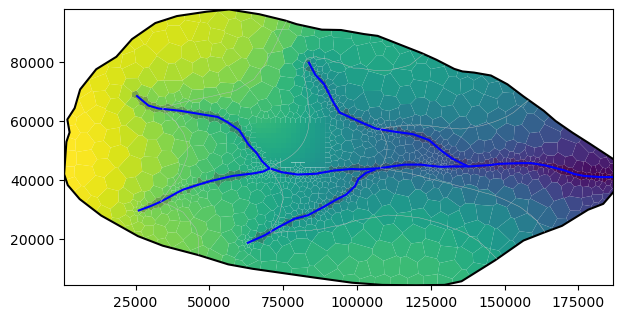

In [33]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=voronoi_grid)
ax.set_aspect("equal")
pmv.plot_array(top_vg)
pmv.plot_array(
    intersection_vg,
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
pmv.plot_inactive()
ax.plot(bpp[:, 0], bpp[:, 1], "k-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

cg = pmv.contour_array(top_vg, levels=levels, linewidths=0.3, colors="0.75")

In [34]:
lgr_poly_array = np.array(lgr_poly).squeeze()

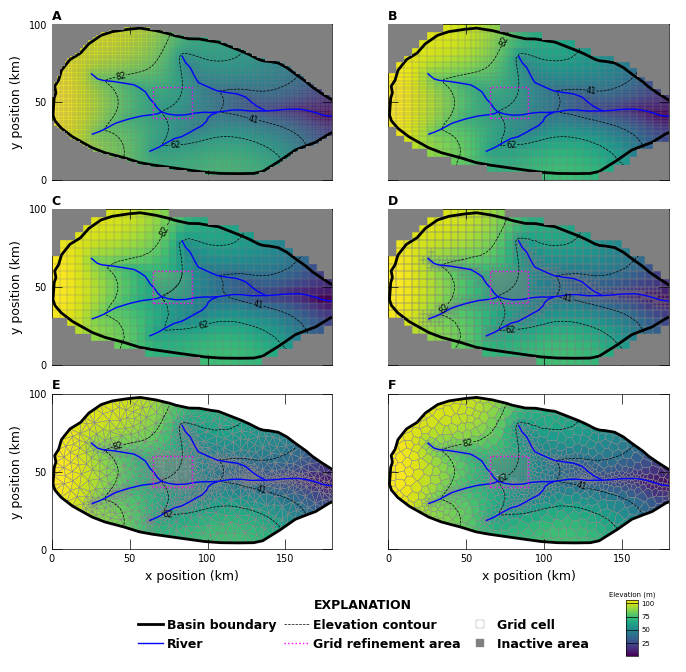

In [35]:
# Make a plot of the six grids
figwidth = 17.15 / 2.54
figheight = 3.66 * (Ly / Lx) * 8.25 / 2.54
grids = [
    struct_grid,
    struct_vrc_grid,
    nested_grid,
    quadtree_grid,
    triangular_grid,
    voronoi_grid,
    None,
]
topo_grids = [top_sg, top_sg_vrc, top_nested_grid, top_qg, top_tg, top_vg]
extent = (0, 180000, 0, 100000)
cbar_axis = [0.0, 0.1, 0.25, 0.9]

with styles.USGSMap():
    fig = plt.figure(figsize=(figwidth, figheight), constrained_layout=True)
    gs = gridspec.GridSpec(ncols=16, nrows=17, figure=fig)
    axs = [fig.add_subplot(gs[:5, :8])]
    axs.append(fig.add_subplot(gs[:5, 8:]))
    axs.append(fig.add_subplot(gs[5:10, :8]))
    axs.append(fig.add_subplot(gs[5:10, 8:]))
    axs.append(fig.add_subplot(gs[10:15, :8]))
    axs.append(fig.add_subplot(gs[10:15, 8:]))
    axs.append(fig.add_subplot(gs[15:, :]))

    for idx, ax in enumerate(axs[:-1]):
        g = grids[idx]
        t = topo_grids[idx]
        if g is not None:
            if isinstance(g, list):
                g = g[0]
                t = t[0]

            pmv = flopy.plot.PlotMapView(modelgrid=g, ax=ax)

            v = pmv.plot_array(t)
            pmv.plot_grid(**grid_dict)
            cg = pmv.contour_array(t, **contour_dict)
            pmv.ax.clabel(cg, cg.levels, **clabel_dict)
            pmv.plot_inactive(color_noflow="gray", zorder=100)

            if isinstance(grids[idx], list):
                gg = grids[idx]
                tt = topo_grids[idx]
                for g, t in zip(gg[1:], tt[1:]):
                    pmvc = flopy.plot.PlotMapView(
                        modelgrid=g, ax=ax, extent=extent
                    )
                    pmvc.plot_array(top_ngc, vmin=vmin, vmax=vmax)
                    pmvc.plot_grid(**grid_dict)
                    cgc = pmvc.contour_array(top_ngc, **contour_dict)

            # plot lgr polyline
            ax.plot(
                lgr_poly_array[:, 0],
                lgr_poly_array[:, 1],
                zorder=101,
                **refinement_dict,
            )

            ax.set_aspect("equal")
            ax.set_axisbelow(False)

            ax.set_xlim(extent[0], extent[1])
            ax.set_xticks(np.arange(0, 200000, 50000))
            if idx in (4, 5):
                ax.set_xticklabels(np.arange(0, 200, 50))
                ax.set_xlabel("x position (km)")
            else:
                ax.set_xticklabels([])

            ax.set_ylim(extent[2], extent[3])
            ax.set_yticks(np.arange(0, 150000, 50000))
            if idx in (0, 2, 4):
                ax.set_yticklabels(np.arange(0, 150, 50))
                ax.set_ylabel("y position (km)")
            else:
                ax.set_yticklabels([])

            styles.heading(ax, idx=idx)
            if True:
                ax.plot(bpp[:, 0], bpp[:, 1], "k-", lw=2.0)
                for sg in sgs:
                    sa = np.array(sg)
                    ax.plot(sa[:, 0], sa[:, 1], **river_dict)

    # legend
    ax = axs[-1]
    xy0 = (-100, -100)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_axis_off()

    ax.axhline(
        xy0[0],
        color="black",
        lw=2,
        label="Basin boundary",
    )
    ax.axhline(
        xy0[0],
        **river_dict,
        label="River",
    )
    ax.axhline(
        xy0[0],
        color=contour_color,
        lw=0.5,
        ls="--",
        label="Elevation contour",
    )
    ax.axhline(
        xy0[0],
        label="Grid refinement area",
        **refinement_dict,
    )
    ax.axhline(
        xy0[0],
        marker="s",
        mec="0.5",
        mfc="white",
        markeredgewidth=0.25,
        lw=0,
        label="Grid cell",
    )
    ax.axhline(
        xy0[0],
        marker="s",
        mec="0.5",
        mfc="gray",
        markeredgewidth=0.25,
        lw=0,
        label="Inactive area",
    )
    styles.graph_legend(
        ax,
        ncol=3,
        loc="lower center",
        labelspacing=0.5,
        columnspacing=0.6,
        handletextpad=0.3,
    )

    # colorbar
    ax = fig.add_subplot(gs[15:, 14:])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_axis_off()
    cax = ax.inset_axes(
        cbar_axis,
    )
    #     cax.set_axisbelow(False)
    cbar = plt.colorbar(
        v,
        orientation="vertical",
        cax=cax,
        ticks=[25, 50, 75, 100],
    )
    cbar.ax.tick_params(
        labelsize=5,
        labelcolor="black",
        color="black",
        length=9,
        pad=2,
    )
    cbar.ax.set_title(
        "Elevation (m)", pad=2.5, loc="center", fontdict=font_dict
    )

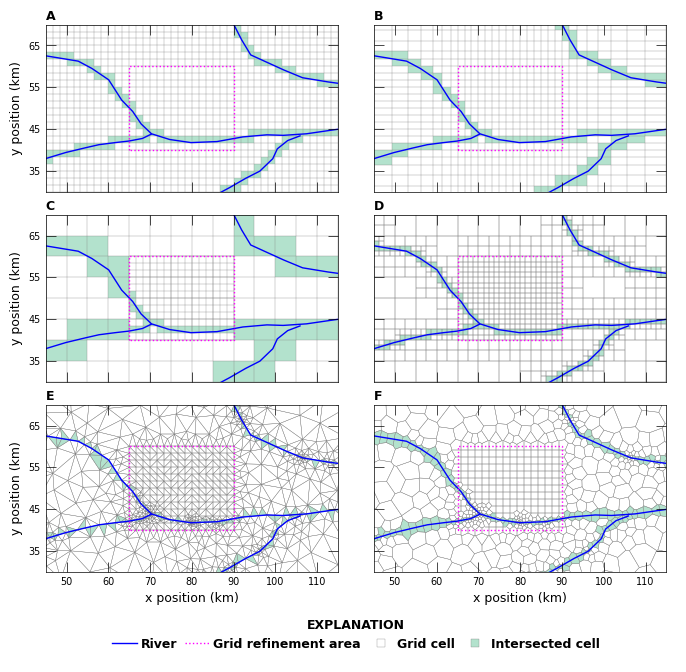

In [36]:
figwidth = 17.15 / 2.54
figheight = 3.66 * (Ly / Lx) * 8.25 / 2.54
grids = [
    struct_grid,
    struct_vrc_grid,
    nested_grid,
    quadtree_grid,
    triangular_grid,
    voronoi_grid,
    None,
]
intersections = [
    intersection_sg,
    intersection_sg_vrc,
    intersection_nested_grid,
    intersection_qg,
    intersection_tg,
    intersection_vg,
    None,
]
extent = list(extent_child)
de = 10000.0
extent[0] -= 2.0 * de
extent[1] += 2.5 * de
extent[2] -= de
extent[3] += de


with styles.USGSMap():
    fig = plt.figure(figsize=(figwidth, figheight), constrained_layout=True)
    gs = gridspec.GridSpec(ncols=2, nrows=16, figure=fig)
    axs = [fig.add_subplot(gs[:5, 0])]
    axs.append(fig.add_subplot(gs[:5, 1]))
    axs.append(fig.add_subplot(gs[5:10, 0]))
    axs.append(fig.add_subplot(gs[5:10, 1]))
    axs.append(fig.add_subplot(gs[10:15, 0]))
    axs.append(fig.add_subplot(gs[10:15, 1]))
    axs.append(fig.add_subplot(gs[15:, :]))

    for idx, ax in enumerate(axs[:-1]):
        g = grids[idx]
        t = intersections[idx]
        if g is not None:
            if isinstance(g, list):
                g = g[0]
                t = t[0]

            pmv = flopy.plot.PlotMapView(modelgrid=g, ax=ax, extent=extent)

            v = pmv.plot_array(t, masked_values=(0,), cmap=intersection_cmap)
            pmv.plot_grid(**grid_dict)

            pmv.plot_inactive(color_noflow="gray", zorder=100)

            if isinstance(grids[idx], list):
                gg = grids[idx]
                tt = intersections[idx]
                for g, t in zip(gg[1:], tt[1:]):
                    pmvc = flopy.plot.PlotMapView(
                        modelgrid=g, ax=ax, extent=extent
                    )
                    pmvc.plot_array(
                        t, masked_values=(0,), cmap=intersection_cmap
                    )
                    pmvc.plot_grid(**grid_dict)

            # plot lgr polyline
            ax.plot(
                lgr_poly_array[:, 0],
                lgr_poly_array[:, 1],
                zorder=101,
                **refinement_dict,
            )

            ax.set_aspect("equal")
            ax.set_axisbelow(False)

            ax.set_xlim(extent[0], extent[1])
            ax.set_xticks(np.arange(50000, 120000, 10000))
            if idx in (4, 5):
                ax.set_xticklabels(np.arange(50, 120, 10))
                ax.set_xlabel("x position (km)")
            else:
                ax.set_xticklabels([])

            ax.set_ylim(extent[2], extent[3])
            ax.set_yticks(np.arange(35000, 70000, 10000))
            if idx in (0, 2, 4):
                ax.set_yticklabels(np.arange(35, 75, 10))
                ax.set_ylabel("y position (km)")
            else:
                ax.set_yticklabels([])

            styles.heading(ax, idx=idx)
            if True:
                ax.plot(bpp[:, 0], bpp[:, 1], "k-", lw=2.0)
                for sg in sgs:
                    sa = np.array(sg)
                    ax.plot(sa[:, 0], sa[:, 1], **river_dict)

    # legend
    ax = axs[-1]
    xy0 = (-100, -100)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_axis_off()

    ax.axhline(xy0[0], **river_dict, label="River")
    ax.axhline(
        xy0[0],
        label="Grid refinement area",
        **refinement_dict,
    )
    ax.axhline(
        xy0[0],
        marker="s",
        mec="0.5",
        mfc="white",
        markeredgewidth=0.25,
        lw=0,
        label="Grid cell",
    )
    ax.axhline(
        xy0[0],
        marker="s",
        mfc=intersection_rgba,
        mec="0.5",
        markeredgewidth=0.25,
        lw=0,
        label="Intersected cell",
    )
    styles.graph_legend(
        ax,
        ncol=4,
        loc="lower center",
        labelspacing=0.5,
        columnspacing=0.6,
        handletextpad=0.3,
    )